In [2]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [7]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [8]:
from classification.models.mlp import MLPClassifier, MLPClassifierv2
from classification.models.flow_mlp import FlowClassifier
import argparse
import yaml

# Helper functions

In [9]:
def logsumexp_1p(s):
    # numerically stable implementation of log sigmoid via logsumexp
    # NOTE: this assumes that you feed in -s for the positive probabilities
    if len(s.size()) == 2:
        s = s.squeeze()
    x = torch.stack([s, torch.zeros_like(s)], -1)
    val, _ = torch.max(x, 1)
    val = val.repeat(2,1).T
    logsigmoid = torch.clamp(s, 0) + torch.log(
        torch.sum(torch.exp(x - val), 1))

    return -logsigmoid

# Dataset

In [10]:
import torch
from torch.distributions import Normal

In [11]:
p = Normal(0, 1)
q = Normal(3, 1)

In [12]:
px = p.sample((2000,2))
qx = q.sample((2000,2))

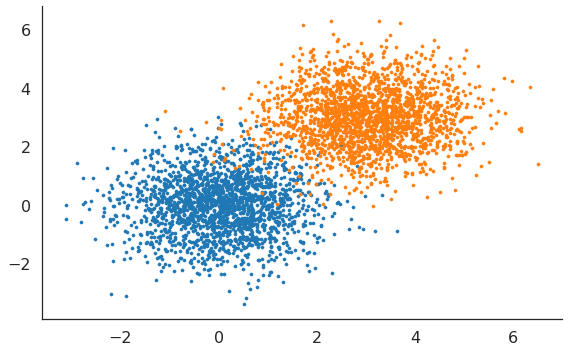

In [13]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label='px', s=10)
plt.scatter(qx[:,0], qx[:,1], label='qx', s=10)

plt.tight_layout()
sns.despine()

In [14]:
true_xs = torch.cat([px, qx])
true_xs.shape

torch.Size([4000, 2])

In [15]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))

In [16]:
true_log_r = torch.log(true_ratios)

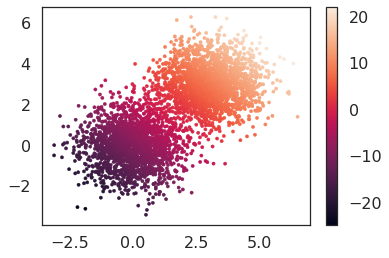

In [17]:
plt.scatter(true_xs[:,0].data.cpu().numpy(), true_xs[:,1].data.cpu().numpy(), s=10, c=true_log_r.data.cpu().numpy())
plt.colorbar()

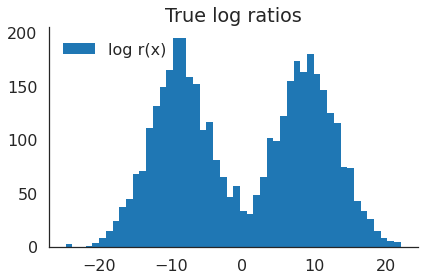

In [18]:
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('True log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

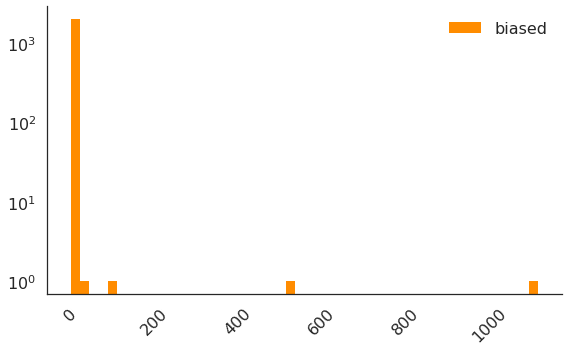

In [19]:
plt.figure(figsize=(8,5))
_ = plt.hist(torch.exp(true_log_r).data.cpu().numpy()[0:2000], bins=50, log=True ,label='biased', color='darkorange')
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

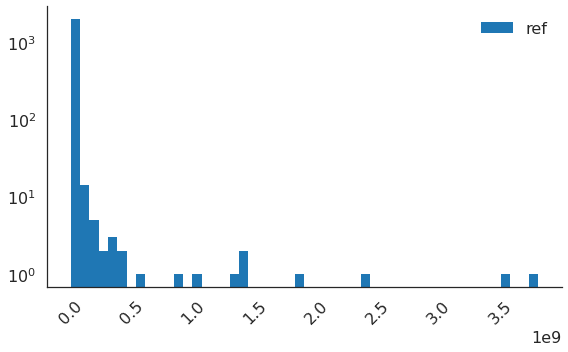

In [20]:
plt.figure(figsize=(8,5))
_ = plt.hist(torch.exp(true_log_r).data.cpu().numpy()[2000:], bins=50, log=True ,label='ref')
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

------

# DRE Clf in X-Space

In [21]:
device = 'cuda'

In [22]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    if isinstance(config, list):
        # from creating config files
        for i in range(len(config)):
            for key, value in config[i].items():
                if isinstance(value, dict):
                    new_value = dict2namespace(value)
                else:
                    new_value = value
                setattr(namespace, key, new_value)
    else:
        # vanilla training
        for key, value in config.items():
            if isinstance(value, dict):
                new_value = dict2namespace(value)
            else:
                new_value = value
            setattr(namespace, key, new_value)
    return namespace

In [23]:
with open(os.path.join('configs/classification/gmm/mlp_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [24]:
x_mlp = MLPClassifierv2(new_config)
restore_file = 'classification/results/gmm_perc1.0_v2/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
x_mlp.load_state_dict(state['state_dict'])
x_mlp = x_mlp.to(device)

In [28]:
# get dres
logits, probas = x_mlp(true_xs.cuda())
ratios = probas/(1-probas)
# reweight these!!!!
# ratios = (ratios)/(0.5 * ratios + 0.5)
log_ratios = torch.log(ratios).squeeze()

In [29]:
len(log_ratios)

4000

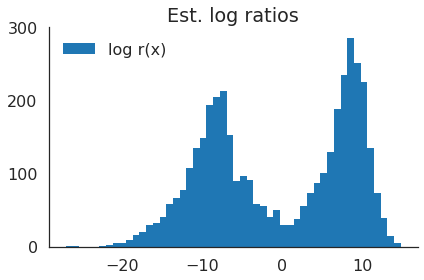

In [30]:
_ = plt.hist(log_ratios.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('Est. log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

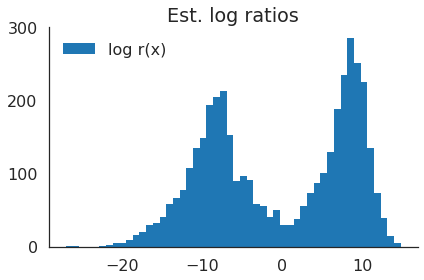

In [31]:
_ = plt.hist(log_ratios.data.cpu().numpy(), bins=50, label='log r(x)')
# _ = plt.hist(ratios.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('Est. log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

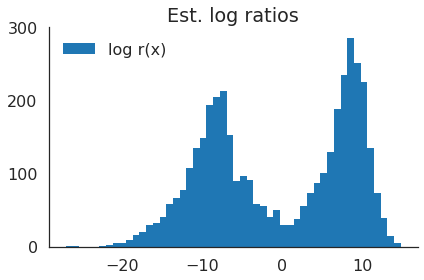

In [32]:
_ = plt.hist(log_ratios.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('Est. log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

In [42]:
torch.norm(
    torch.cat([state['state_dict']['fc4.weight'], state['state_dict']['fc4.bias'].view(-1, 1)], dim=1)
)

tensor(0.6878, device='cuda:0')

# Deeper DRE Clf in z-space (baseline)

x -> z = flow(x) -> clf(z)

In [46]:
with open(os.path.join('configs/classification/gmm/flow_mlp_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [47]:
flow_mlp = FlowClassifier(new_config)
restore_file = 'classification/results/gmm_flow_mlp_perc1.0/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
flow_mlp.load_state_dict(state['state_dict'])
flow_mlp = flow_mlp.to(device)

In [48]:
torch.norm(
    torch.cat([state['state_dict']['fc4.weight'], state['state_dict']['fc4.bias'].view(-1, 1)], dim=1)
)

tensor(1.0096, device='cuda:0')

In [44]:
# get dres
logits, probas = flow_mlp(true_xs.cuda())
ratios = probas/(1-probas)
flow_log_ratios = torch.log(ratios).squeeze()

In [45]:
(flow_log_ratios==np.inf).sum()

tensor(0, device='cuda:0')

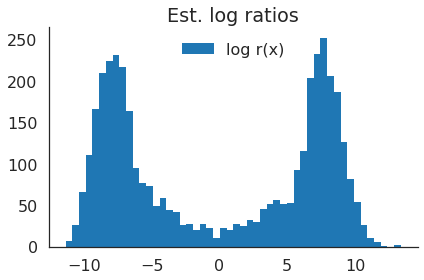

In [46]:
_ = plt.hist(flow_log_ratios.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('Est. log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

# Z-Space

In [25]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [49]:
device = 'cuda'

In [50]:
with open(os.path.join('configs/classification/gmm/mlp_z_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [54]:
z_mlp = MLPClassifierv2(new_config)
restore_file = 'classification/results/gmm_z_perc1.0_v2/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
z_mlp.load_state_dict(state['state_dict'])
z_mlp = z_mlp.to(device)

In [55]:
torch.norm(
    torch.cat([state['state_dict']['fc4.weight'], state['state_dict']['fc4.bias'].view(-1, 1)], dim=1)
)

tensor(1.0793, device='cuda:0')

In [52]:
# load flow
import os
from flows.models.maf import MAF

model = MAF(5, 
            2, 
            100, 
            1, 
            None, 
            'relu', 
            'sequential', 
            batch_norm=True)
restore_file = 'flows/results/gmm_perc1.0/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
model.load_state_dict(state['model_state'])
model = model.to(device)
model.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

In [34]:
z, _ = model.forward(true_xs.cuda())

In [35]:
# get dres
logits, probas = z_mlp(z.cuda())
z_log_ratios = (logsumexp_1p(-logits) - logsumexp_1p(logits)).squeeze()

In [36]:
(z_log_ratios==np.inf).sum()

tensor(0, device='cuda:0')

In [37]:
len(z_log_ratios)

4000

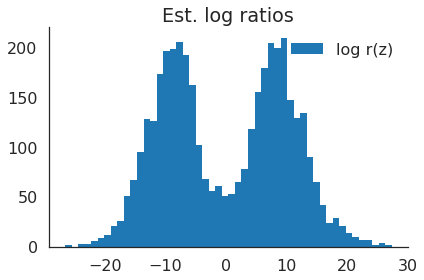

In [38]:
_ = plt.hist(z_log_ratios.data.cpu().numpy(), bins=50, label='log r(z)')
plt.title('Est. log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

--------

# Jointly trained flow classifier

In [ ]:
loss = alpha * clf_loss + (1-alpha) * flow_loss

In [56]:
with open(os.path.join('configs/classification/gmm/joint_flow_mlp_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [57]:
joint_flow_mlp = FlowClassifier(new_config)
restore_file = 'classification/results/joint_gmm_flow_mlp_perc1.0/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
joint_flow_mlp.load_state_dict(state['state_dict'])
joint_flow_mlp = joint_flow_mlp.to(device)

In [58]:
torch.norm(
    torch.cat([state['state_dict']['fc4.weight'], state['state_dict']['fc4.bias'].view(-1, 1)], dim=1)
)

tensor(0.8980, device='cuda:0')

In [66]:
# get dres
logits, probas = joint_flow_mlp(true_xs.cuda())
joint_flow_log_ratios = (logsumexp_1p(-logits) - logsumexp_1p(logits)).squeeze()

In [67]:
(joint_flow_log_ratios==np.inf).sum()

tensor(0, device='cuda:0')

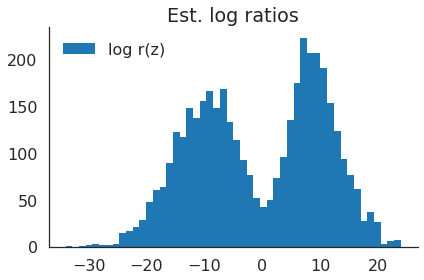

In [68]:
_ = plt.hist(joint_flow_log_ratios.data.cpu().numpy(), bins=50, label='log r(z)')
plt.title('Est. log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

----

### Compare the two

In [40]:
len(true_log_r)

4000

In [41]:
len(z_log_ratios)

4000

In [42]:
len(log_ratios)

4000

In [43]:
len(flow_log_ratios)

4000

In [55]:
len(joint_flow_log_ratios)

4000

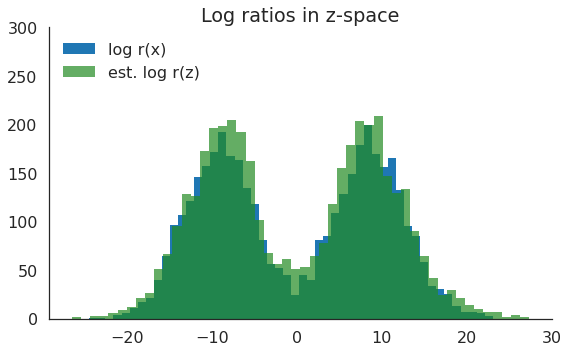

In [39]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.detach().data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(z_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z)', alpha=0.7, color='forestgreen')
plt.title('Log ratios in z-space')
plt.ylim(0, 300)

plt.legend(loc='upper left')
sns.despine()
plt.tight_layout()

In [ ]:
# train dre classifier, don't do this
p = torch.sigmoid(logits)
r = p/(1-p)

# compute log ratios first, then exp() to get actual ratios
log_r = utils.logsumexp_1p(-logits) - utils.logsumexp_1p(logits)
r = torch.exp(log_r)

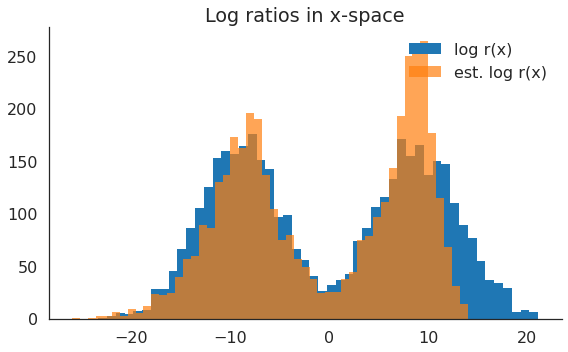

In [45]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(log_ratios.data.cpu().numpy(), bins=50, label='est. log r(x)', alpha=0.7)
plt.title('Log ratios in x-space')
plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()

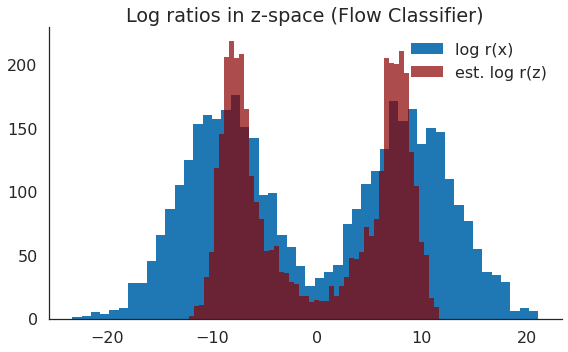

In [46]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(flow_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z)', alpha=0.7, color='darkred')
plt.title('Log ratios in z-space (Flow Classifier)')
plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()

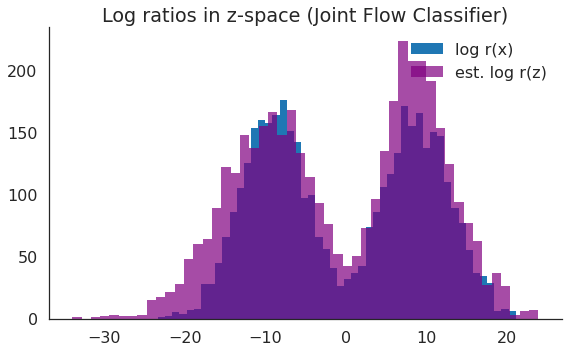

In [69]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(joint_flow_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z)', alpha=0.7, color='purple')
plt.title('Log ratios in z-space (Joint Flow Classifier)')
plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()

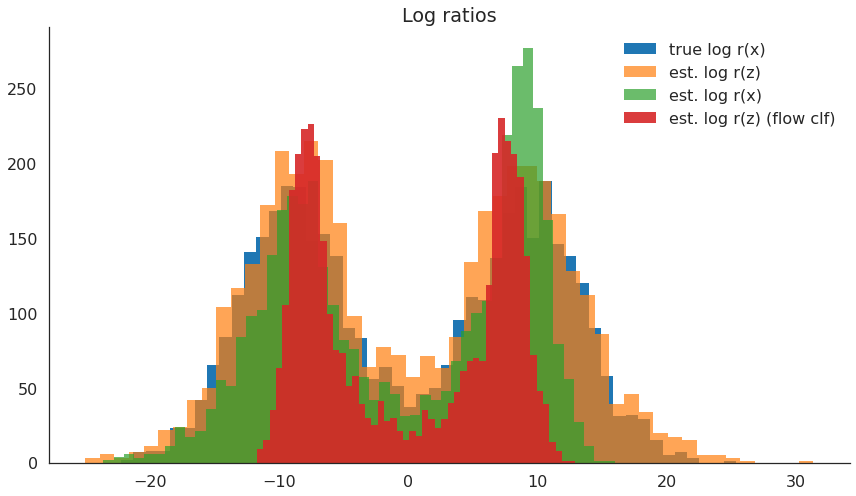

In [130]:
plt.figure(figsize=(12,7))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='true log r(x)')
_ = plt.hist(z_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z)', alpha=0.7)
_ = plt.hist(log_ratios.data.cpu().numpy(), bins=50, label='est. log r(x)', alpha=0.7)
_ = plt.hist(flow_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z) (flow clf)', alpha=0.9)
plt.title('Log ratios')

plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()

In [66]:
z_log_ratios.size()

torch.Size([4000])

In [67]:
true_log_r.size()

torch.Size([4000])

In [68]:
log_ratios.size()

torch.Size([4000])

------

# Can you scatter?

In [107]:
true_log_r = true_log_r.data.cpu().numpy()
log_ratios = log_ratios.data.cpu().numpy()
z_log_ratios = z_log_ratios.data.cpu().numpy()

In [108]:
all_ratios = np.vstack([true_log_r, log_ratios, z_log_ratios])
min_, max_ = all_ratios.min(), all_ratios.max()

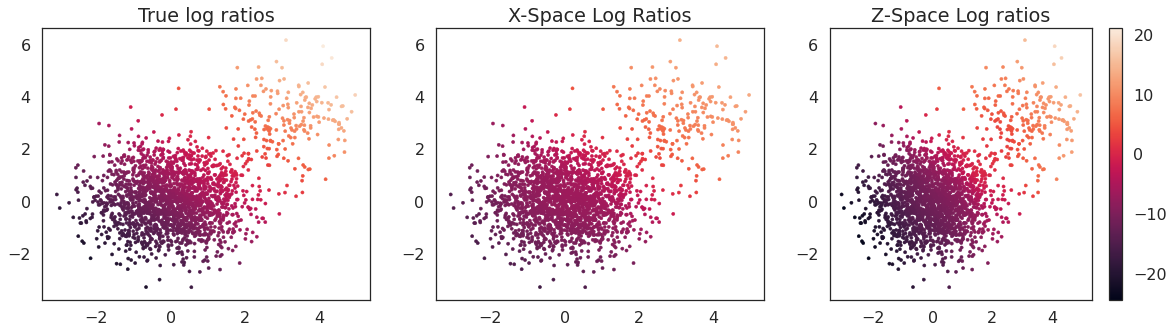

In [128]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=true_log_r)
plt.clim(min_, max_)
# plt.colorbar()
plt.title('True log ratios')

plt.subplot(1,3,2)
# x-space dre clf
plt.title('X-Space Log Ratios')
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=log_ratios)
plt.clim(min_, max_)
# plt.colorbar()

# z-space
plt.subplot(1,3,3)
plt.title('Z-Space Log ratios')
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=z_log_ratios)
plt.clim(min_, max_)
plt.colorbar()

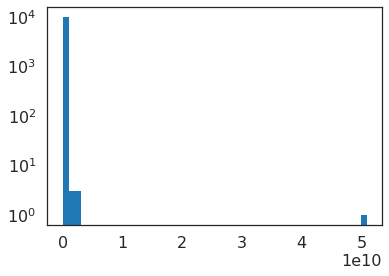

In [123]:
_ = plt.hist(true_r.data.cpu().numpy(), bins=50)
plt.yscale('log')

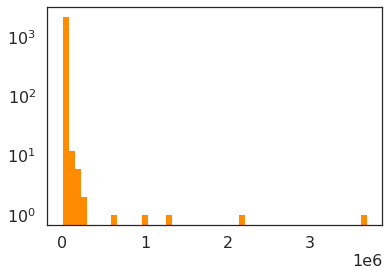

In [124]:
_ = plt.hist(np.exp(log_ratios), bins=50, color='darkorange')
plt.yscale('log')

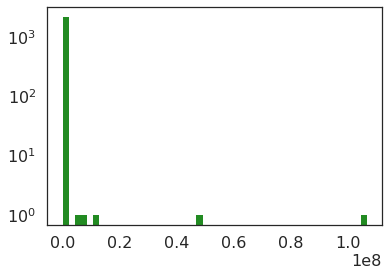

In [125]:
# _ = plt.hist(true_r.data.cpu().numpy(), bins=50)
_ = plt.hist(np.exp(z_log_ratios), bins=50, color='forestgreen')
plt.yscale('log')

----